In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from loggers import Logger

In [7]:
loggers = Logger("userEngagement.log").get_app_logger()
loggers.info("Initialized userEngagement.py logger")

[27/Aug/2022 16:40:32] INFO - Initialized userEngagement.py logger


In [8]:
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')

In [9]:
df = df_org.copy()

In [10]:
pl = Plot()
overview = Overview(df)

[27/Aug/2022 17:07:50] INFO - Successfully Instantiated Preprocessing Class Object
[27/Aug/2022 17:07:50] INFO - Successfully Instantiated Outlier Class Object


In [11]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,...,Total UL (Bytes),Total DL (Bytes),social_media,google,email,youtube,netflix,gaming,other,total_data
0,0,-inf,44.020249,4/4/2019 12:01,6.646391,4/25/2019 14:35,6.495266,14.416352,32.969527,24.239723,...,17.419642,19.548462,-27.179828,-12.748763,-12.506825,-10.905557,-10.933217,5.678213,5.196057,5.845367
1,1,0.000000,44.020249,4/9/2019 13:04,5.459586,4/25/2019 8:15,6.406880,14.126741,32.969529,24.240225,...,17.800791,20.297677,-26.971804,-12.330708,-13.880172,-10.142783,-10.244133,6.413329,6.295191,6.561293
2,2,0.693147,44.020249,4/9/2019 17:42,0.000000,4/25/2019 11:58,6.480045,14.124290,32.969522,24.242561,...,17.143551,19.449612,-27.085054,-11.490272,-12.602640,-10.276721,-10.647877,5.437993,6.028058,5.729096
3,3,1.098612,44.020249,4/10/2019 0:31,6.186209,4/25/2019 7:36,5.141664,14.094285,32.969527,24.242256,...,17.584222,20.556064,-28.050342,-11.346415,-13.087487,-10.217246,-11.101307,6.697513,6.635733,6.790494
4,4,1.386294,44.020249,4/12/2019 20:10,6.336826,4/25/2019 10:40,6.860664,13.900779,32.969527,24.240758,...,17.467280,20.159635,-27.722273,-11.767967,-13.068657,-10.282634,-10.951038,6.275208,6.336153,6.409651


In [14]:
df = df.rename( columns={'Bearer Id': 'sessions'})

In [16]:
user_engagement = df.groupby('MSISDN/Number').agg({'sessions': 'count', 'Dur. (ms)': 'sum', 'total_data': 'sum'})


In [17]:
user_engagement.head()

,sessions,Dur. (ms),total_data
MSISDN/Number,,,
24.237822,1,11.667533,6.778433
24.237822,1,12.107522,5.055351
24.237822,1,11.812800,6.390184
24.237822,1,10.817335,6.045765
24.237822,2,19.656666,13.143197


#### Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 

In [18]:
user_engagement.shape


(106856, 3)

In [26]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "Dur. (ms)")['Dur. (ms)']
total_data = user_engagement.nlargest(10, "total_data")['total_data']

In [32]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [33]:
sesssions_df.head()

,User_ID,Sessions
0,24.239686,1067
1,24.238575,18
2,24.238235,17
3,24.238559,17
4,24.239568,16


In [34]:
durations_df.head()

,User_ID,duration
0,24.239686,11474.784780
1,24.238559,233.413129
2,24.238575,231.977427
3,24.238235,222.446521
4,24.239568,198.016024


In [30]:
total_data_df.head()

,User_ID,total_data
0,24.239686,6451.672649
1,24.238575,107.793076
2,24.238235,103.652870
3,24.238559,103.623238
4,24.239568,95.490500


[]

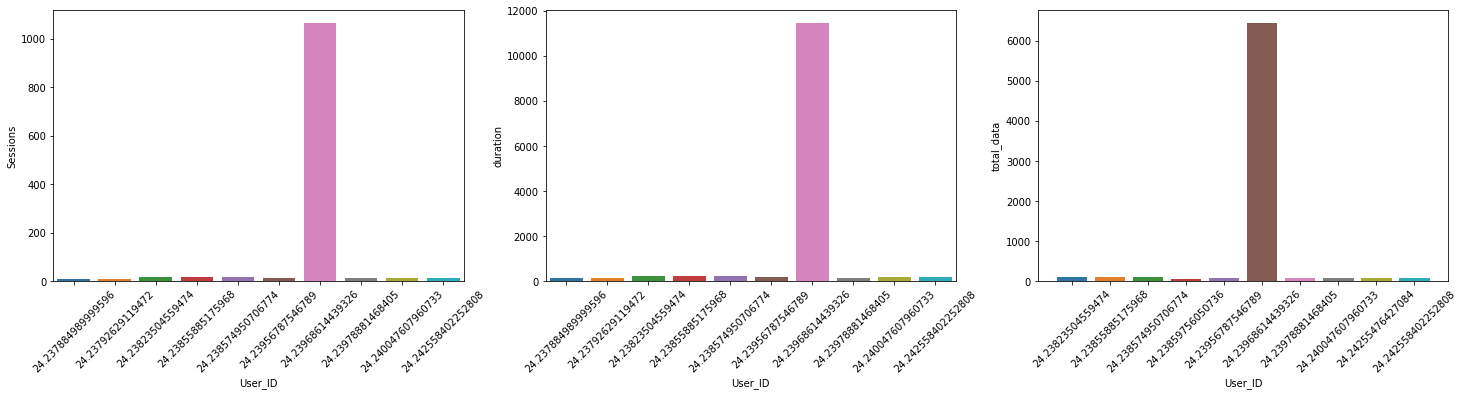

In [35]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

In [36]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    return pd.DataFrame(norm.fit_transform(df), columns=columns)


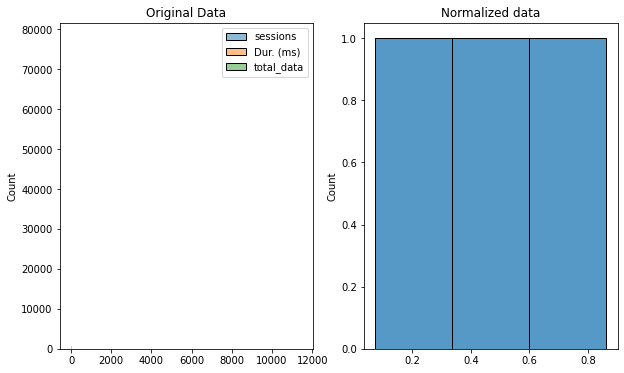

In [38]:
normalized_user_engagement = normalizer(user_engagement, ['sessions', 'Dur. (ms)', 'total_data'] )

In [39]:
normalized_user_engagement.head()

,sessions,Dur. (ms),total_data
0,0.073906,0.862304,0.500969
1,0.075996,0.920123,0.384186
2,0.074252,0.877126,0.474485
3,0.080435,0.870088,0.486289
4,0.084280,0.828335,0.553857


In [40]:
normalized_user_engagement.describe()

,sessions,Dur. (ms),total_data
count,106856.000000,106856.000000,106856.000000
mean,0.077967,0.877781,0.470060
std,0.004361,0.023141,0.043711
min,0.063789,0.792003,0.277730
25%,0.075117,0.863705,0.444631
50%,0.077088,0.876988,0.474364
75%,0.080240,0.892356,0.498022
max,0.100446,0.957425,0.604044


In [45]:
normalized__eng = normalized_user_engagement.copy()

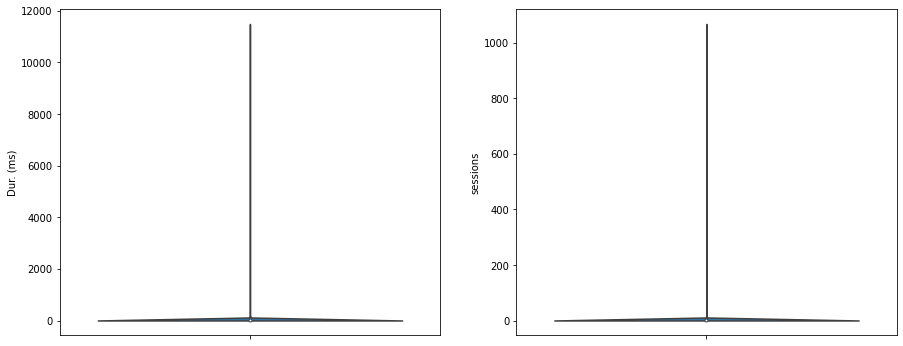

In [46]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=user_engagement["Dur. (ms)"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=user_engagement["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()

In [48]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized__eng)
centroids = kmeans.cluster_centers_

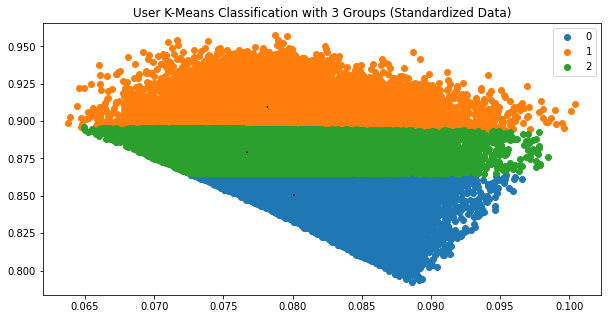

In [49]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized__eng[label == i].iloc[:,0] , normalized__eng[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [52]:
loggers.info(f'# Centroids of the clustering:\n{centroids}')
loggers.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
loggers.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

[27/Aug/2022 17:41:36] INFO - # Centroids of the clustering:
[[0.08009894 0.85048028 0.51926622]
 [0.07818572 0.90938692 0.40752989]
 [0.07670908 0.87904351 0.47018571]]
[27/Aug/2022 17:41:36] INFO - # The number of iterations required to converge: 55.23557709160564
[27/Aug/2022 17:41:36] INFO - # The number of iterations required to converge: 11


In [53]:
normalized__eng.head()

,sessions,Dur. (ms),total_data
0,0.073906,0.862304,0.500969
1,0.075996,0.920123,0.384186
2,0.074252,0.877126,0.474485
3,0.080435,0.870088,0.486289
4,0.084280,0.828335,0.553857


In [54]:
clustered_Df = pd.DataFrame()
clustered_Df['data_index'] = normalized__eng.index.values
clustered_Df['cluster'] = kmeans.labels_

In [55]:
clustered_Df.cluster.value_counts()

2    53985
0    29610
1    23261
Name: cluster, dtype: int64

In [56]:
u_eng = user_engagement.copy()

In [57]:
u_eng.insert(0, 'cluster', kmeans.labels_)
u_eng.head(5)

,cluster,sessions,Dur. (ms),total_data
MSISDN/Number,,,,
24.237822,0,1,11.667533,6.778433
24.237822,1,1,12.107522,5.055351
24.237822,2,1,11.812800,6.390184
24.237822,2,1,10.817335,6.045765
24.237822,0,2,19.656666,13.143197


In [58]:
cluster1 = u_eng[u_eng["cluster"]==0]
cluster1.describe()

,cluster,sessions,Dur. (ms),total_data
count,29610.0,29610.000000,29610.000000,29610.000000
mean,0.0,1.242891,13.250092,8.049641
std,0.0,0.523265,5.705725,3.337156
min,0.0,1.000000,8.873748,5.161386
25%,0.0,1.000000,10.253942,6.471567
50%,0.0,1.000000,11.136500,6.669994
75%,0.0,1.000000,11.561330,6.804740
max,0.0,7.000000,70.557294,43.870378


In [59]:
cluster2 = u_eng[u_eng["cluster"] == 1]
cluster2.describe()

,cluster,sessions,Dur. (ms),total_data
count,23261.0,23261.000000,23261.000000,23261.000000
mean,1.0,1.324922,15.506116,7.021615
std,0.0,0.832235,10.216663,4.890089
min,1.0,1.000000,8.991438,3.504025
25%,1.0,1.000000,11.366743,4.930699
50%,1.0,1.000000,11.884317,5.379832
75%,1.0,1.000000,12.611331,5.888051
max,1.0,18.000000,233.413129,107.793076


In [60]:
cluster3 = u_eng[u_eng["cluster"] == 2]
cluster3.describe()

,cluster,sessions,Dur. (ms),total_data
count,53985.0,53985.000000,53985.000000,53985.000000
mean,2.0,1.525979,17.492390,9.341799
std,0.0,4.673291,50.389580,28.261969
min,2.0,1.000000,8.894670,4.492538
25%,2.0,1.000000,11.366743,6.095191
50%,2.0,1.000000,11.940446,6.471265
75%,2.0,2.000000,22.733393,11.907636
max,2.0,1067.000000,11474.784780,6451.672649


In [61]:
cluster3.sessions.count()

53985

[27/Aug/2022 17:41:51] INFO - Plotting a pie chart


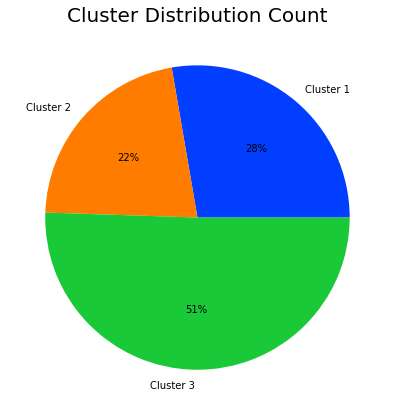

In [62]:
data = [cluster1.sessions.count(), cluster2.sessions.count(), cluster3.sessions.count()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count")

In [64]:
user_app_usage = df.groupby(
    'MSISDN/Number').agg({ 'social_media': 'sum', 'gaming': 'sum', 'youtube': 'sum', 'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'other': 'sum'})


In [65]:
user_app_usage.head()

,social_media,gaming,youtube,netflix,google,email,other
MSISDN/Number,,,,,,,
24.237822,24.758478,6.700065,-10.741681,-10.512993,-12.336408,-13.529308,5.957315
24.237822,25.805627,4.785407,-11.295219,-11.397656,-12.141247,-12.619233,5.640878
24.237822,25.733266,6.289396,-10.755229,-10.852617,-12.579131,-12.650680,6.217990
24.237822,22.704073,5.969030,-11.872846,-13.151745,-11.545604,-12.989289,3.563308
24.237822,48.636766,12.926592,-21.564513,-21.236933,-23.191775,-26.647301,11.031821


In [67]:


social_media = user_app_usage.nlargest(10, "social_media")['social_media']
gaming = user_app_usage.nlargest(10, "gaming")['gaming']
youtube = user_app_usage.nlargest(10, "youtube")['youtube']
netflix = user_app_usage.nlargest(10, "netflix")['netflix']
google = user_app_usage.nlargest(10, "google")['google']
email = user_app_usage.nlargest(10, "email")['email']
other = user_app_usage.nlargest(10, "other")['other']



In [68]:
social_media_df = pd.DataFrame()
social_media_df['User_ID'] = social_media.index
social_media_df['social_media'] = social_media.values
gaming_df = pd.DataFrame()
gaming_df['User_ID'] = gaming.index
gaming_df['gaming'] = gaming.values
youtube_df = pd.DataFrame()
youtube_df['User_ID'] = youtube.index
youtube_df['youtube'] = youtube.values

netflix_df = pd.DataFrame()
netflix_df['User_ID'] = netflix.index
netflix_df['netflix'] = netflix.values
google_df = pd.DataFrame()
google_df['User_ID'] = google.index
google_df['google'] = google.values
email_df = pd.DataFrame()
email_df['User_ID'] = email.index
email_df['email'] = email.values
others_df = pd.DataFrame()
others_df['User_ID'] = other.index
others_df['other'] = other.values

##### Most Engaged user per application

[]

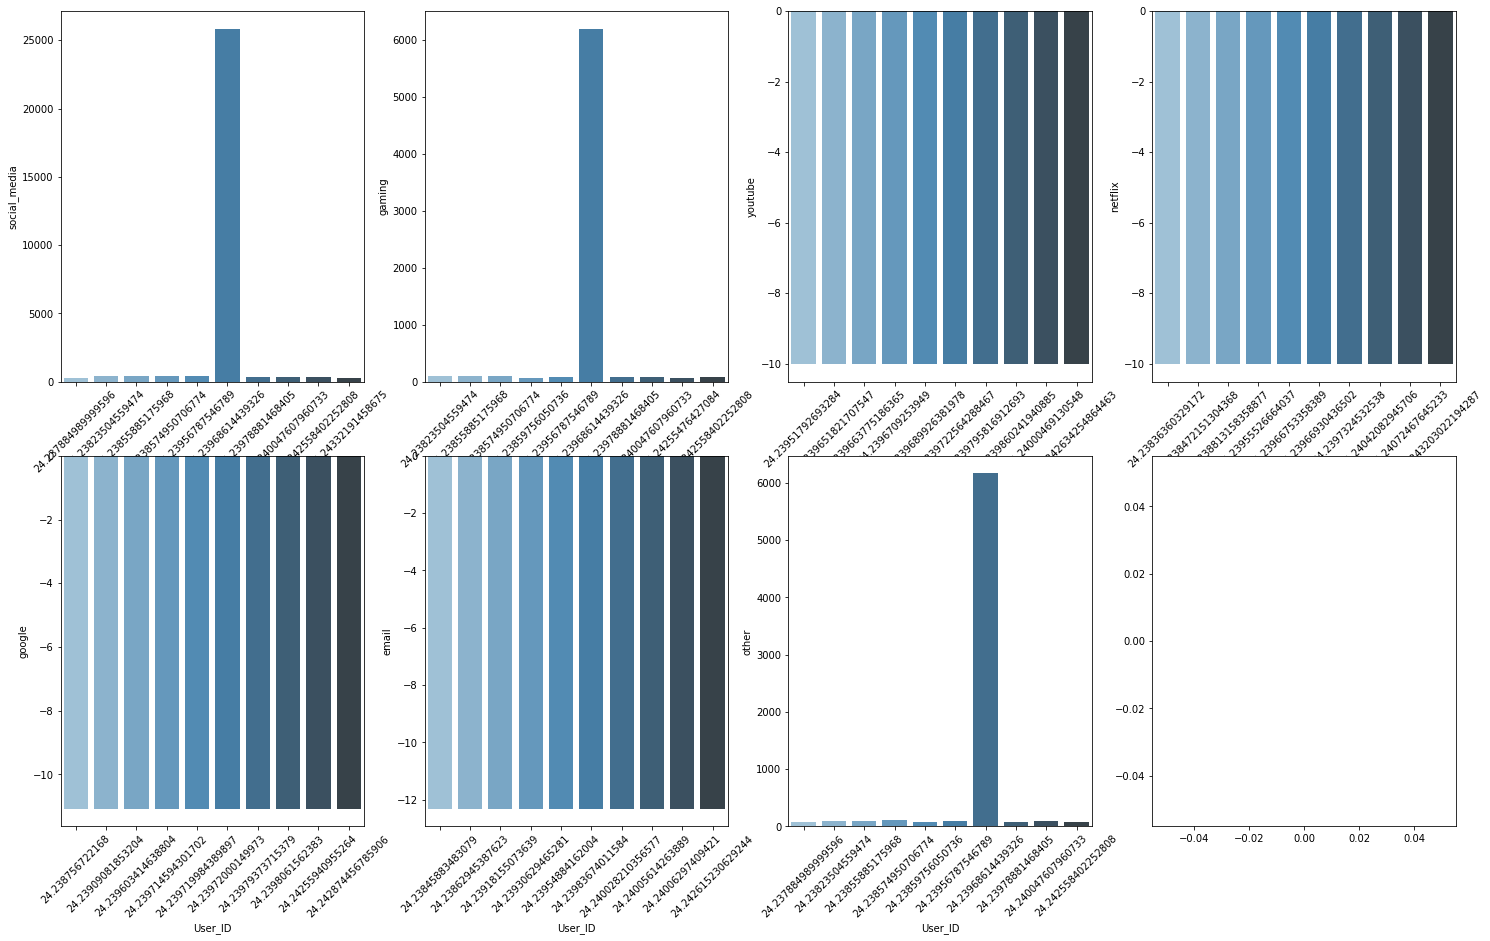

In [69]:


f, axes = plt.subplots(2, 4, figsize=(25, 15))
ax1 = sns.barplot(data=social_media_df, x='User_ID', orient='v', y='social_media', ax=axes[0,0], palette='Blues_d')
ax2 = sns.barplot(data=gaming_df, x='User_ID',orient='v', y='gaming', ax=axes[0,1], palette='Blues_d')
ax3 = sns.barplot(data=youtube_df, x='User_ID',orient='v', y='youtube', ax=axes[0,2], palette='Blues_d')
ax4 = sns.barplot(data=netflix_df, x='User_ID',orient='v', y='netflix', ax=axes[0,3], palette='Blues_d')
ax5 = sns.barplot(data=google_df, x='User_ID',orient='v', y='google', ax=axes[1,0], palette='Blues_d')
ax6 = sns.barplot(data=email_df, x='User_ID',orient='v', y='email', ax=axes[1,1], palette='Blues_d')
ax7 = sns.barplot(data=others_df, x='User_ID',orient='v', y='other', ax=axes[1,2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
ax4.set_xticklabels(ax4.xaxis.get_majorticklabels(), rotation=45)
ax5.set_xticklabels(ax5.xaxis.get_majorticklabels(), rotation=45)
ax6.set_xticklabels(ax6.xaxis.get_majorticklabels(), rotation=45)
ax7.set_xticklabels(ax7.xaxis.get_majorticklabels(), rotation=45)
plt.plot()



In [70]:
top_used_applications = user_app_usage.sum()

In [71]:


top_used_applications.values

array([             -inf,   868554.36909735, -1621456.21659238,
       -1621588.14839137, -1785147.99012838, -1973839.91503243,
         868244.29656427])

In [72]:
top_3_used = top_used_applications.nlargest(3)

In [73]:


top_3_used

gaming     8.685544e+05
other      8.682443e+05
youtube   -1.621456e+06
dtype: float64

[27/Aug/2022 17:43:03] INFO - Plotting a bar chart


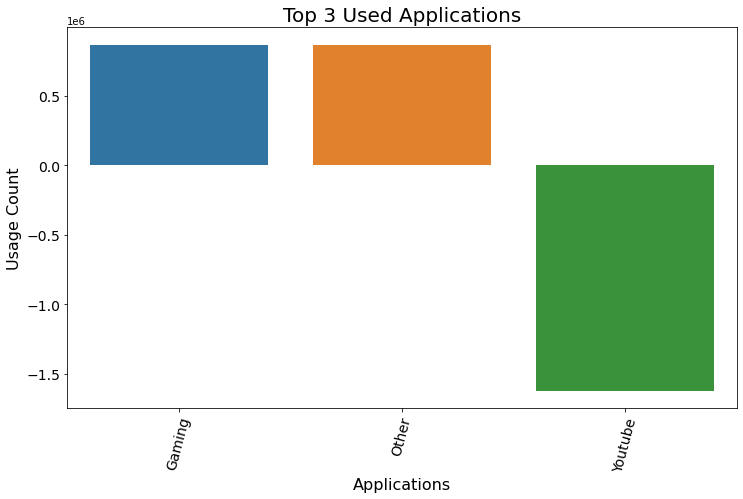

In [74]:
pl.plot_bar(top_3_used, ["Gaming", "Other", "Youtube"], top_3_used.values, "Top 3 Used Applications", "Applications", "Usage Count")



In [75]:


inertias = []
for i in range(1,16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(normalized__eng)
    inertias.append(kmeans.inertia_)



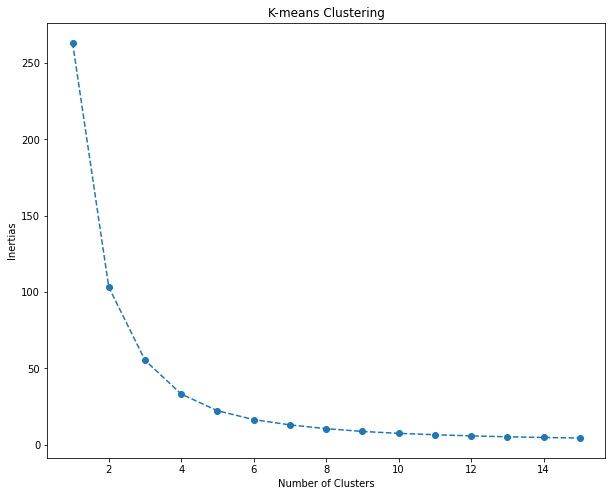

In [76]:
# Plotting the cluster size vs. inertia graph to find the optimal cluster
plt.figure(figsize = (10,8))
plt.plot(range(1, 16), inertias, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('K-means Clustering')
plt.show()

In [77]:
kl = KneeLocator(range(0, 15), inertias, curve="convex", direction="decreasing")
kl.elbow

3

In [79]:
loggers.info(f"The optimal number of cluster is: {kl.elbow}")


[27/Aug/2022 17:44:30] INFO - The optimal number of cluster is: 3


In [80]:
u_eng.shape

(106856, 4)

In [83]:
with open("../models/user_eng.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [81]:
u_eng.to_csv('../data/user_eng.csv')

In [82]:
normalized__eng.to_csv('../data/normalized_eng.csv')